In [1]:
#import graphlab as gl
import numpy as np
import copy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
%matplotlib inline


In [19]:
'''
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data
'''

'\ndef generate_MoG_data(num_data, means, covariances, weights):\n    """ Creates a list of data points """\n    num_clusters = len(weights)\n    data = []\n    for i in range(num_data):\n        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.\n        k = np.random.choice(len(weights), 1, p=weights)[0]\n\n        # Use np.random.multivariate_normal to create data from this cluster\n        x = np.random.multivariate_normal(means[k], covariances[k])\n\n        data.append(x)\n    return data\n'

In [20]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [4]:
def EM(data, init_means, init_covariances, init_weights, maxiter=40, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        # E-step: compute responsibilities
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k]*multivariate_normal.pdf(data[j],means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        counts = np.sum(resp, axis=0)
        for k in range(num_clusters):
            weights[k] = counts[k]/num_data
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += (resp[j,k]*data[j])
            means[k] = weighted_sum/counts[k]
            
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += (resp[j,k]*np.outer(data[j]-means[k],data[j]-means[k]))
            covariances[k] = weighted_sum/counts[k]
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        ll = ll_latest
    
        print("Iteration : {} - means:{}".format(i,means))
        
        plt.figure(figsize=(12,8))
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(means[0][0], means[0][1], color = "red")
        plt.scatter(means[1][0], means[1][1],color="orange")
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [5]:
def normalize_data(X):
    
    X_norm = np.zeros(X.shape)
    X_norm[:,0] = (X[:,0] - np.amin(X[:,0]))/(np.amax(X[:,0]) - np.amin(X[:,0]))
    X_norm[:,1] = (X[:,1] - np.amin(X[:,1]))/(np.amax(X[:,1]) - np.amin(X[:,1]))

    return X_norm

In [6]:
#Load the Data
X = np.loadtxt('data/Faithful.txt')
#X_norm = normalize_data(X)

In [ ]:
# Initialization of parameters
#chosen = np.random.choice(len(data), 3, replace=False)
#initial_means = [data[x] for x in chosen]
#initial_covs = [np.cov(data, rowvar=0)] * 3
#initial_weights = [1/3.] * 3

Iteration : 0 - means:[array([ 3.46774403, 70.13166412]), array([ 3.50782457, 71.66254627])]
Iteration : 1 - means:[array([ 3.46291731, 70.05780029]), array([ 3.5126545 , 71.73650758])]
Iteration : 2 - means:[array([ 3.45664616, 69.95503994]), array([ 3.51893098, 71.83940936])]
Iteration : 3 - means:[array([ 3.44925159, 69.82970329]), array([ 3.5263345 , 71.96496596])]
Iteration : 4 - means:[array([ 3.44062853, 69.68228822]), array([ 3.53497242, 72.11272534])]
Iteration : 5 - means:[array([ 3.43058742, 69.51185803]), array([ 3.54503784, 72.28369052])]
Iteration : 6 - means:[array([ 3.41889448, 69.31672613]), array([ 3.55676996, 72.4796459 ])]
Iteration : 7 - means:[array([ 3.40526984, 69.09458879]), array([ 3.57045706, 72.70303984])]
Iteration : 8 - means:[array([ 3.38937619, 68.84251876]), array([ 3.58644936, 72.95701414])]
Iteration : 9 - means:[array([ 3.37080048, 68.55686684]), array([ 3.60518001, 73.24553884])]
Iteration : 10 - means:[array([ 3.34902589, 68.23306181]), array([ 3.6

/Users/sushanta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration : 21 - means:[array([ 2.39098395, 58.25590449]), array([ 4.35251308, 80.86350114])]
Iteration : 22 - means:[array([ 2.26223779, 56.91726436]), array([ 4.35095277, 80.74323485])]
Iteration : 23 - means:[array([ 2.16206804, 55.81554391]), array([ 4.33568123, 80.54286348])]
Iteration : 24 - means:[array([ 2.09987453, 55.12149718]), array([ 4.31810966, 80.33490545])]
Iteration : 25 - means:[array([ 2.05760264, 54.71218421]), array([ 4.30134441, 80.10386064])]
Iteration : 26 - means:[array([ 2.04024011, 54.5246241 ]), array([ 4.29257933, 79.99970667])]
Iteration : 27 - means:[array([ 2.0371774 , 54.48672831]), array([ 4.29034612, 79.97624877])]
Iteration : 28 - means:[array([ 2.03657217, 54.48037559]), array([ 4.28982403, 79.97006948])]
Iteration : 29 - means:[array([ 2.03643236, 54.47895858]), array([ 4.2897008, 79.9685845])]
Iteration : 30 - means:[array([ 2.03639901, 54.47862255]), array([ 4.28967131, 79.96822809])]
Iteration : 31 - means:[array([ 2.03639099, 54.47854192]), arr

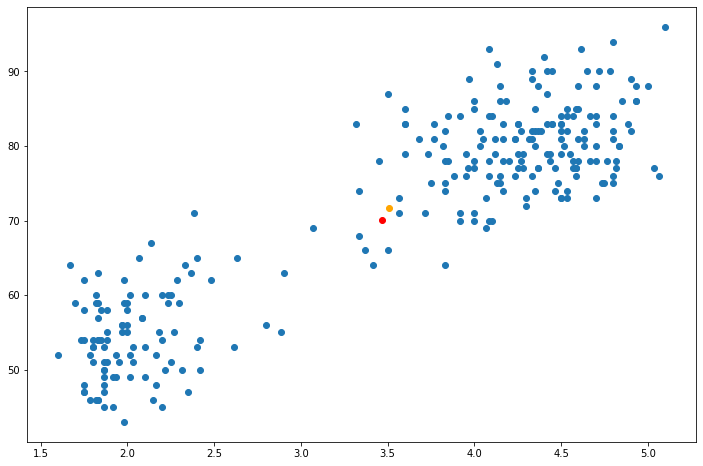

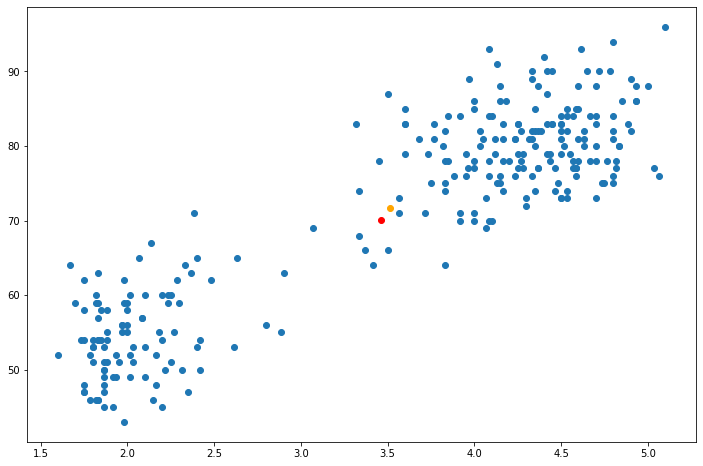

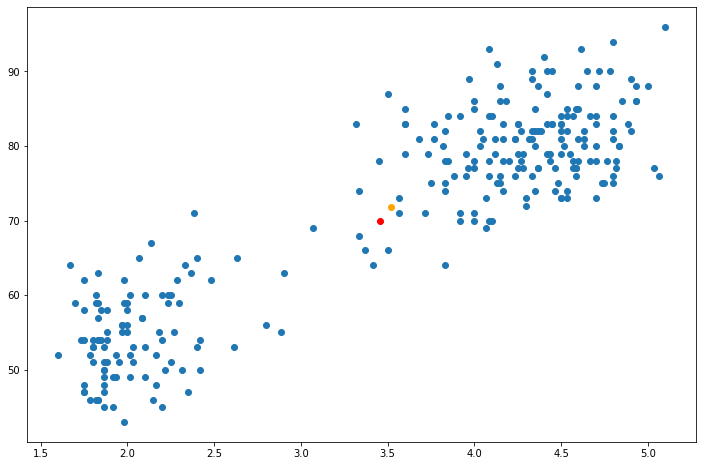

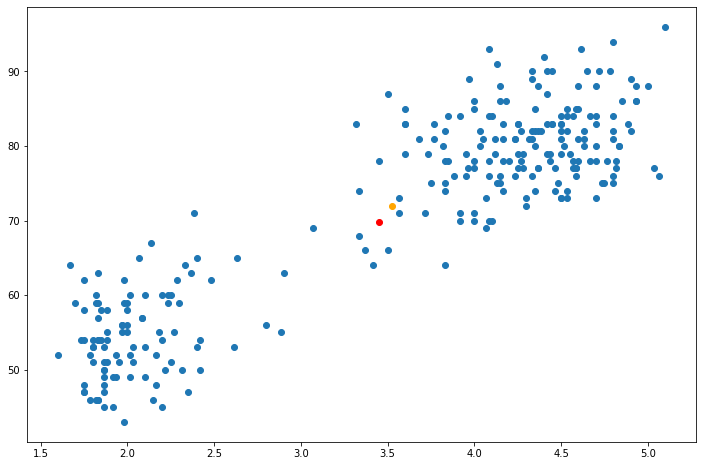

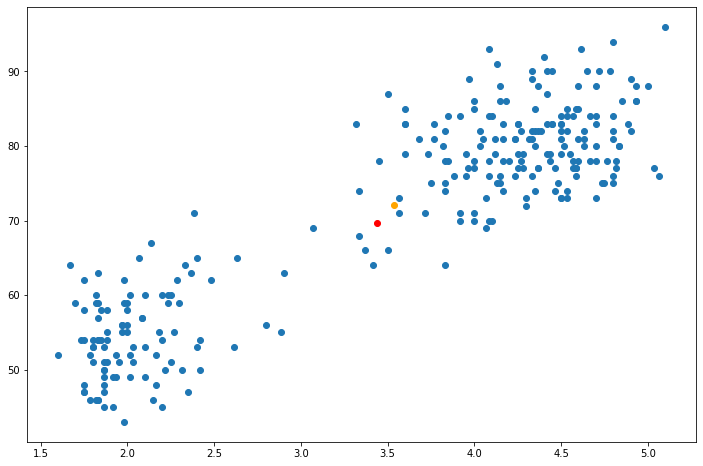

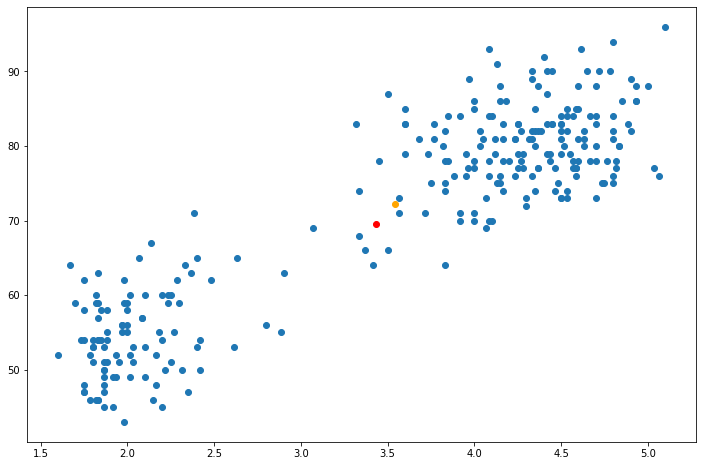

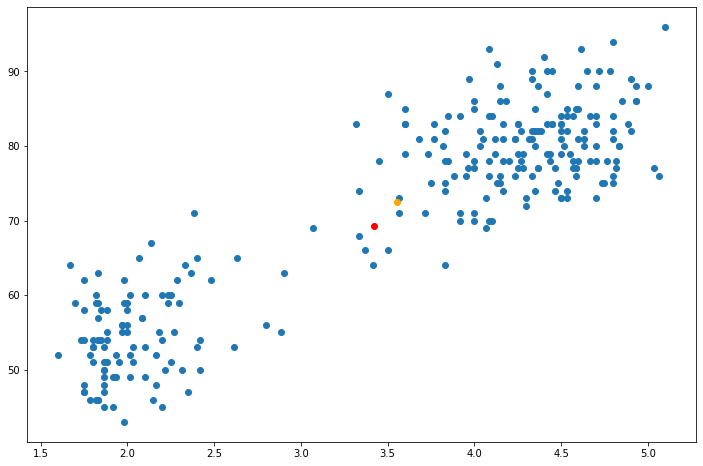

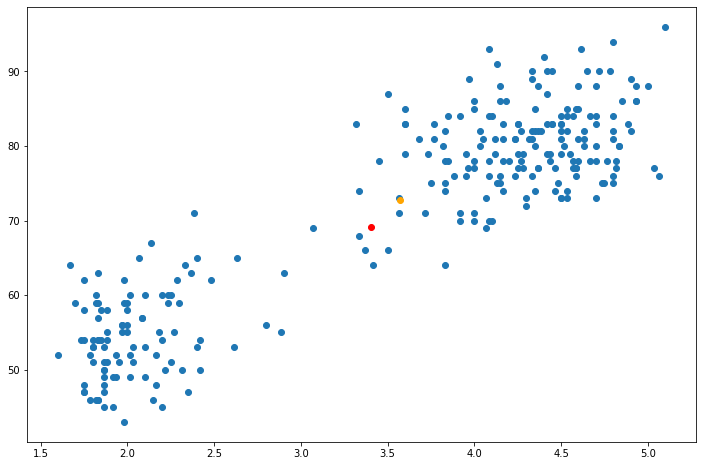

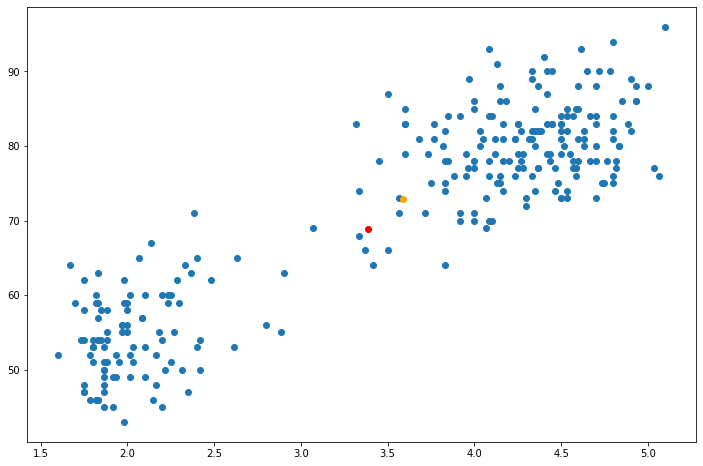

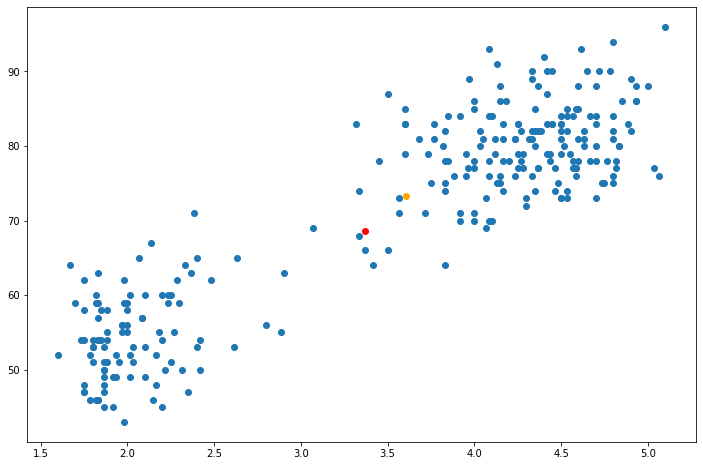

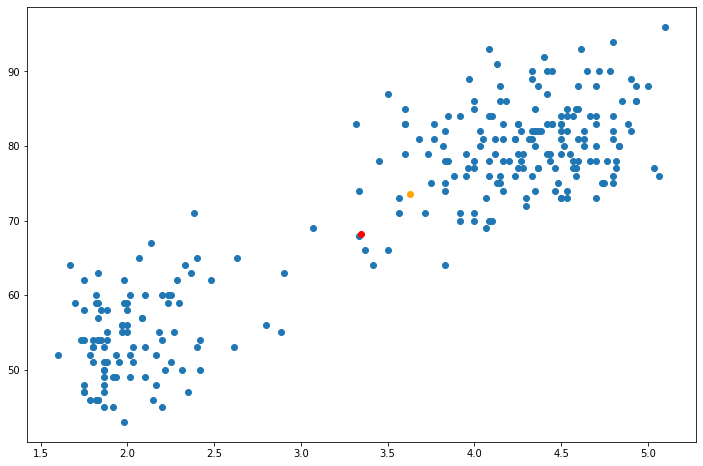

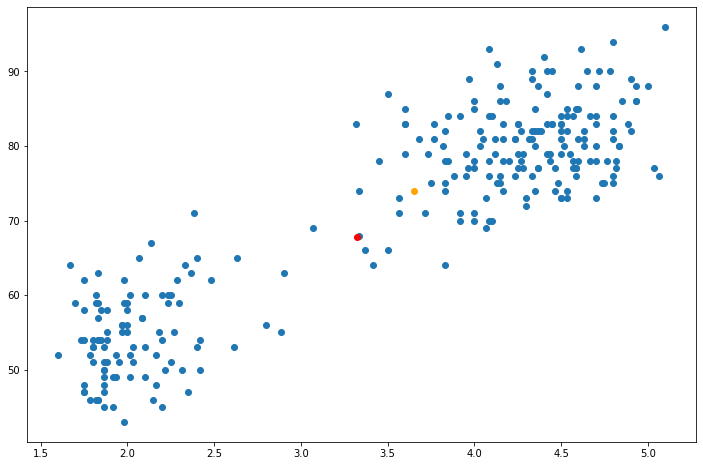

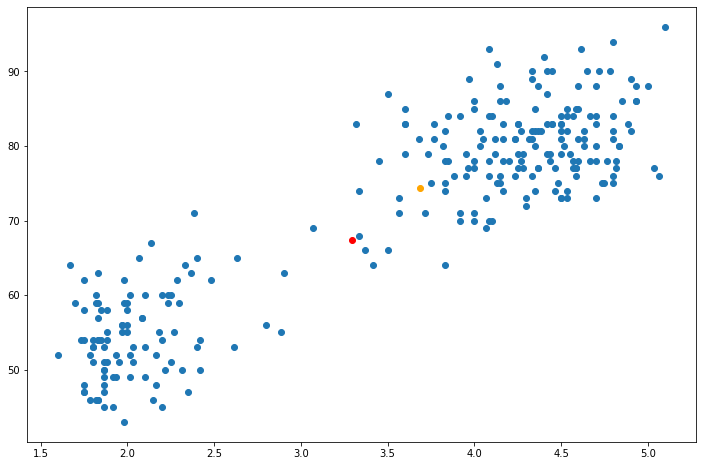

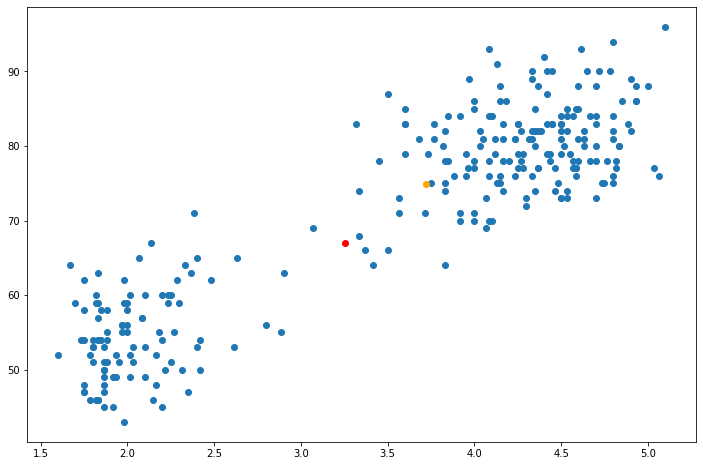

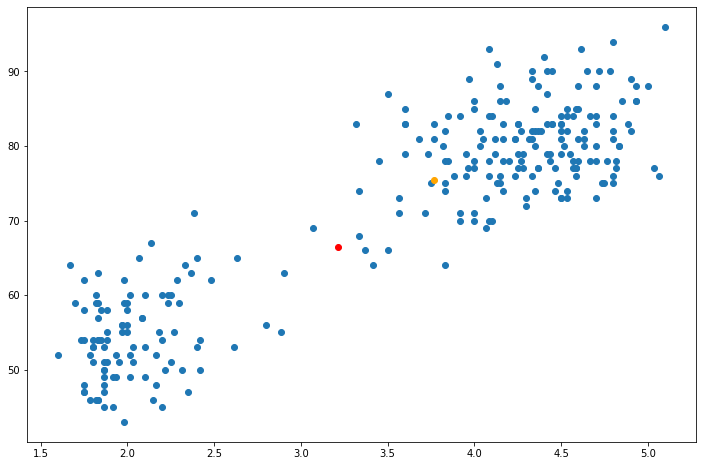

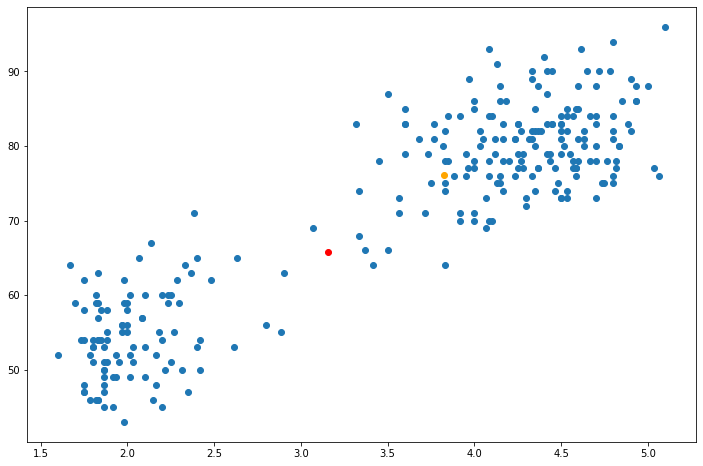

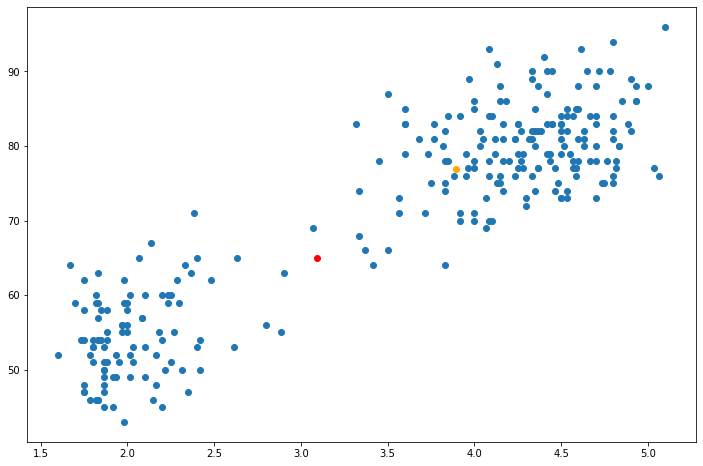

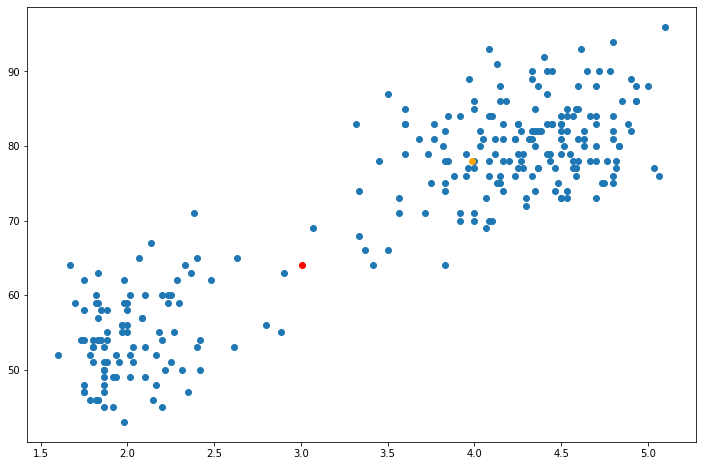

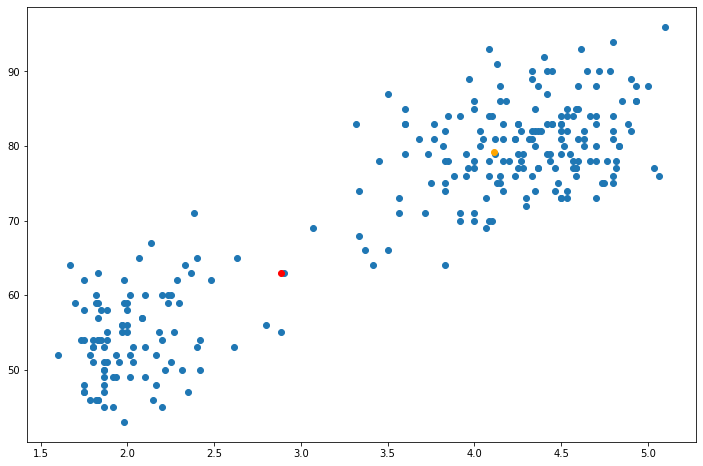

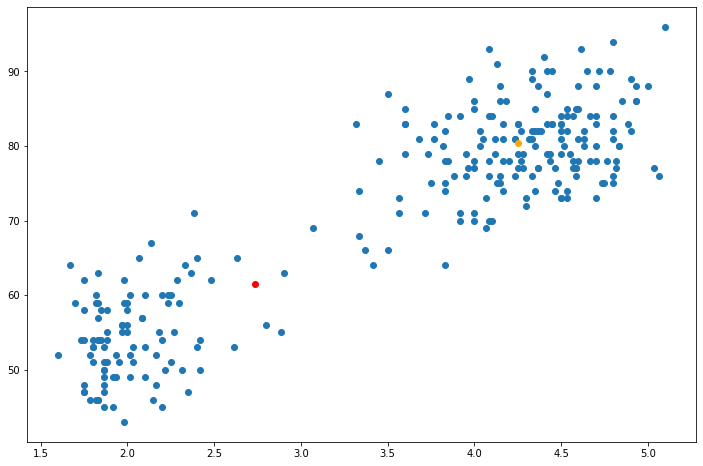

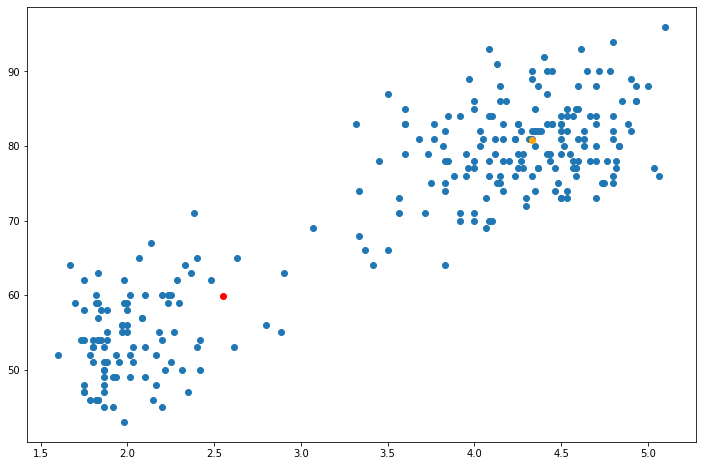

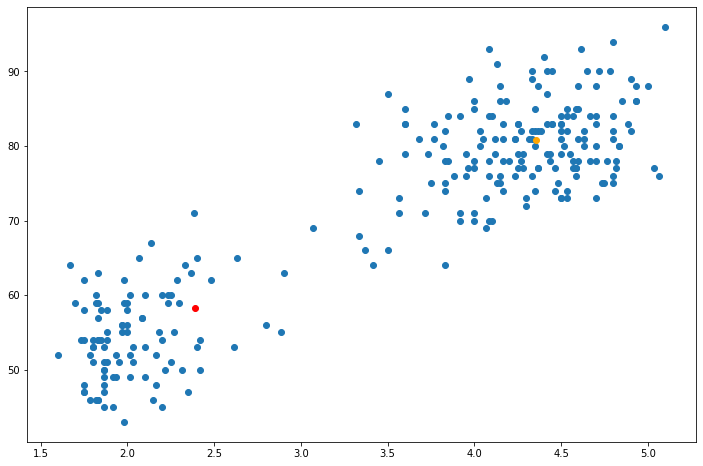

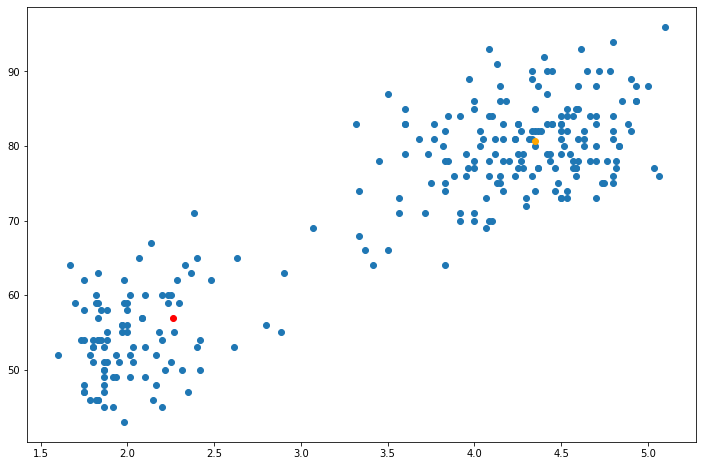

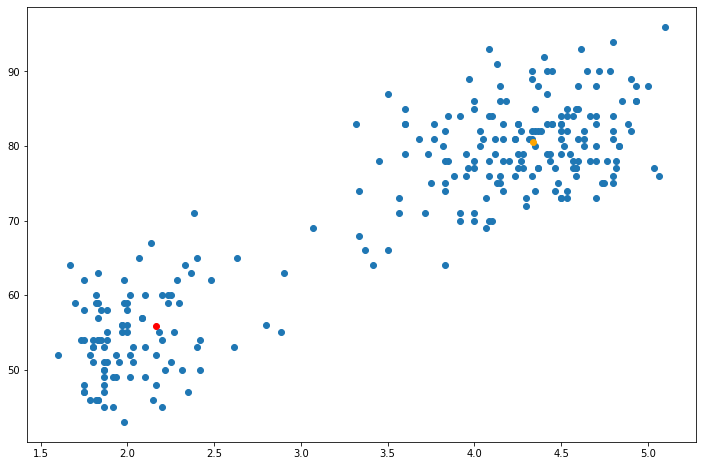

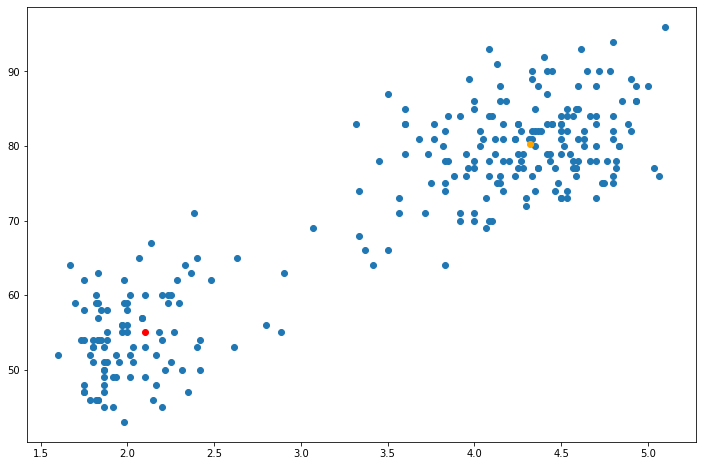

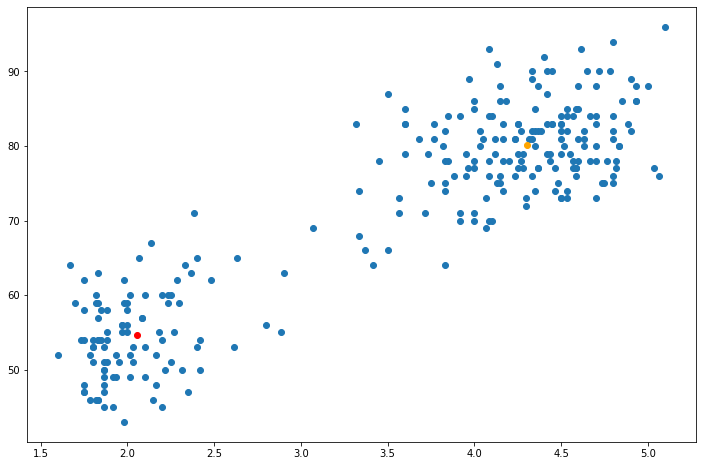

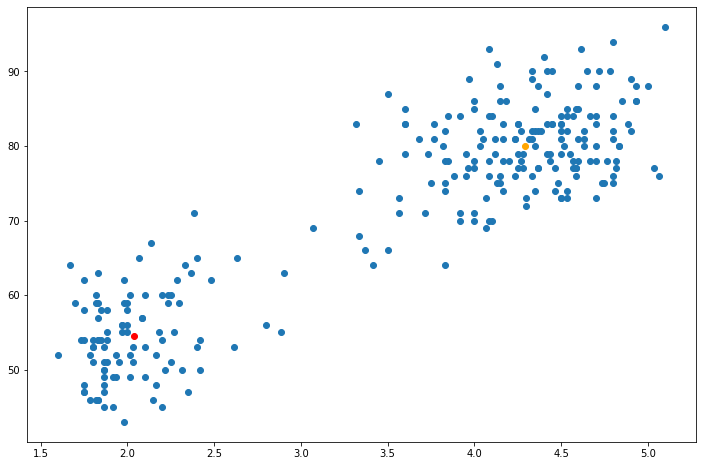

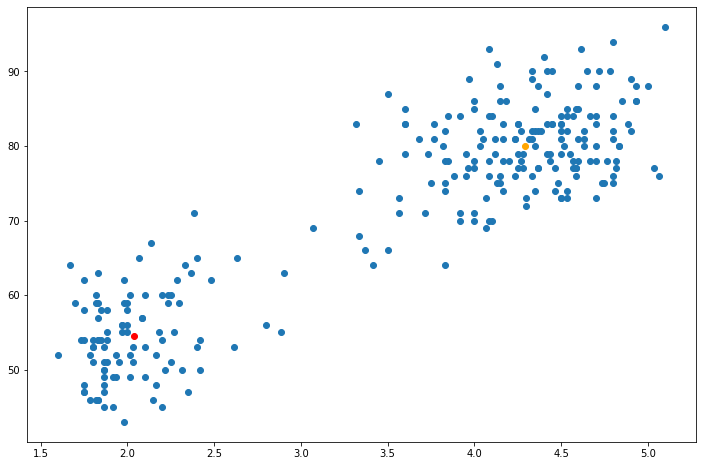

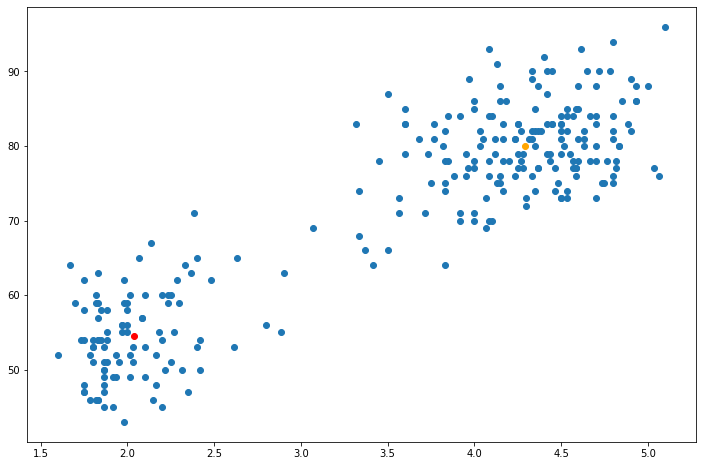

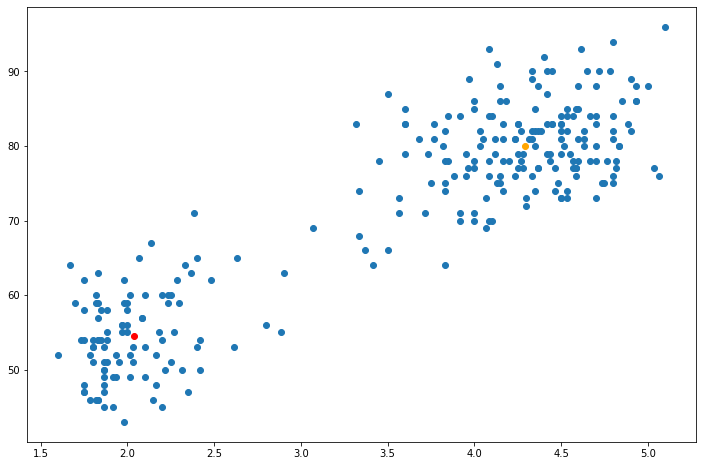

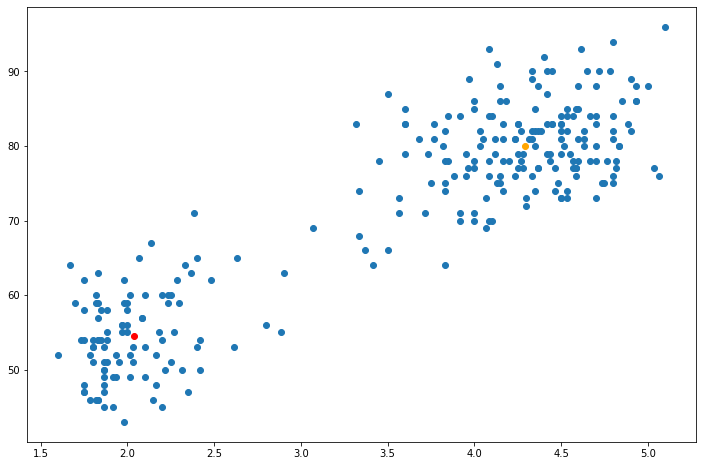

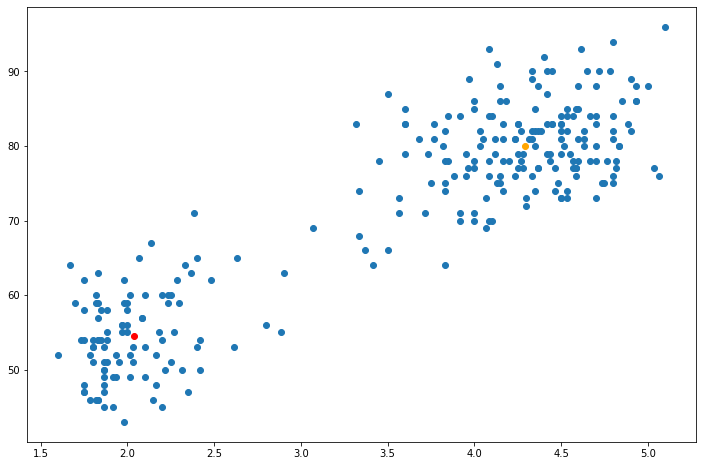

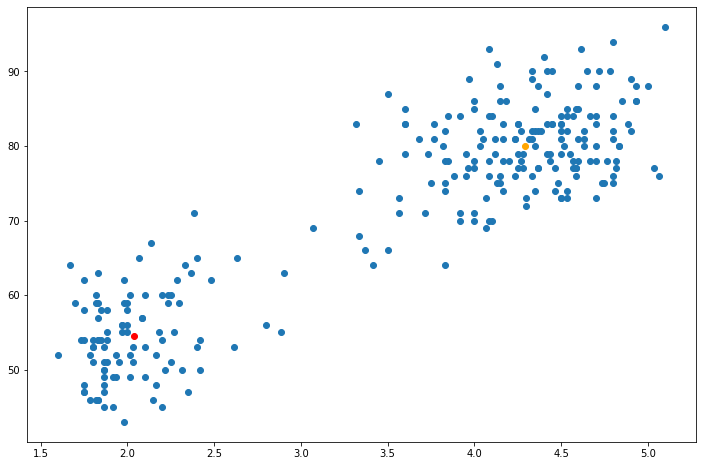

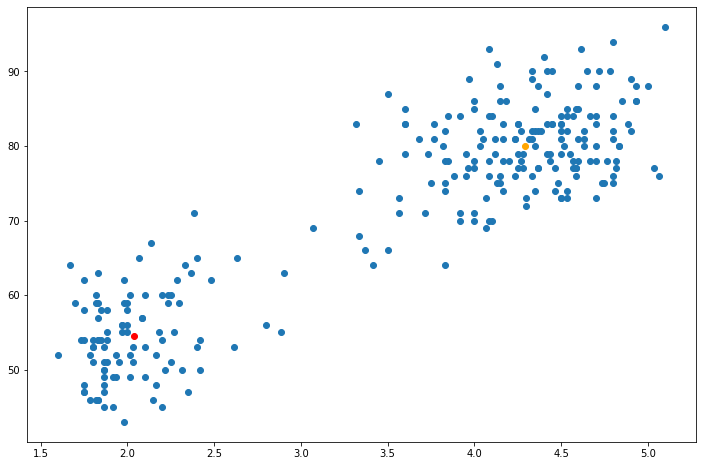

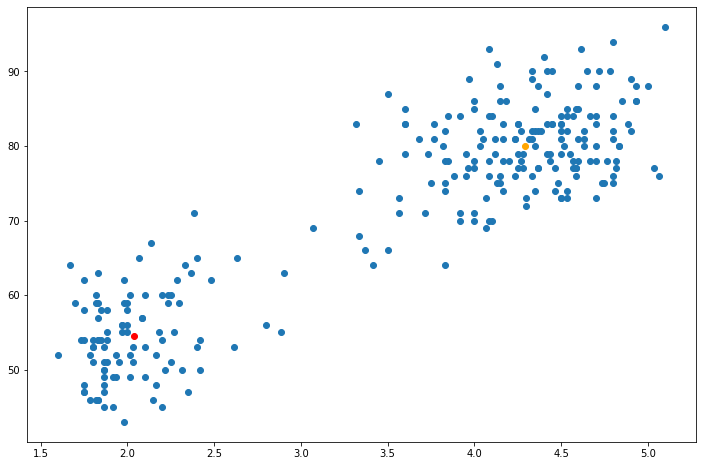

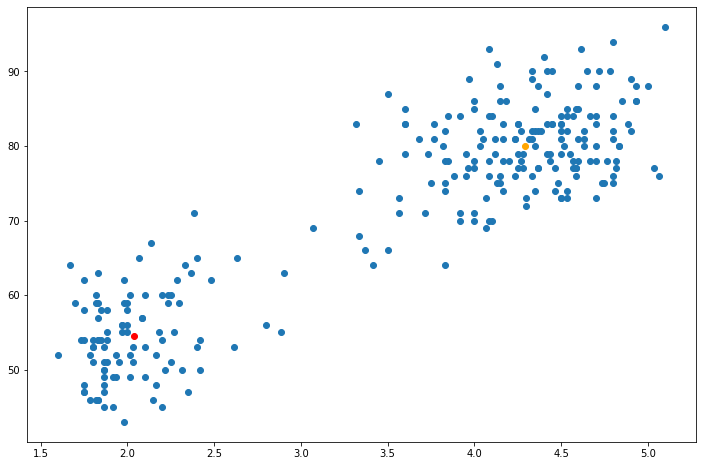

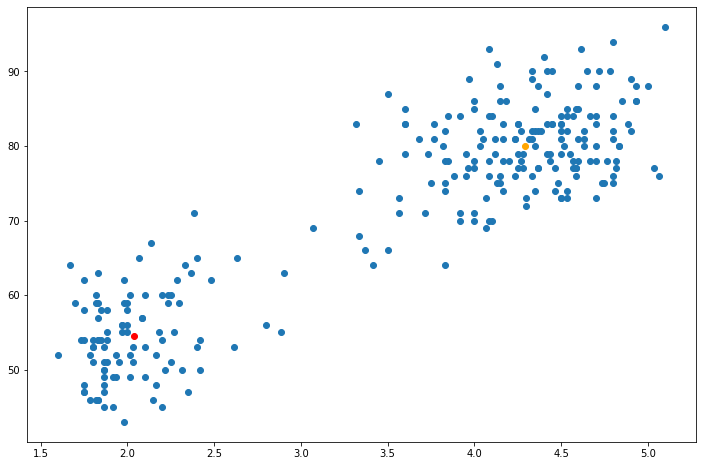

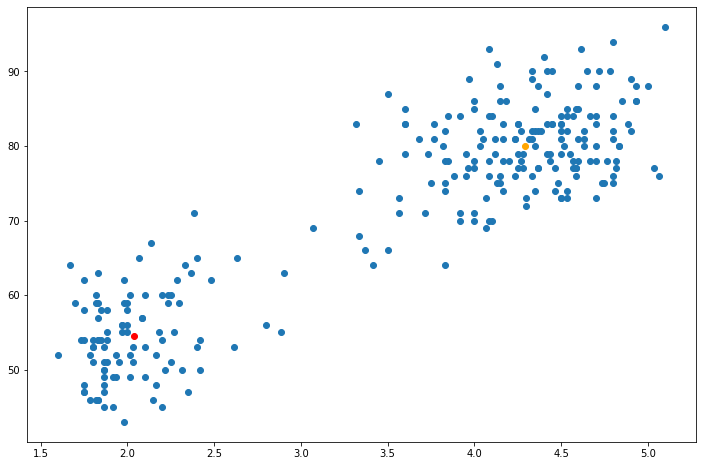

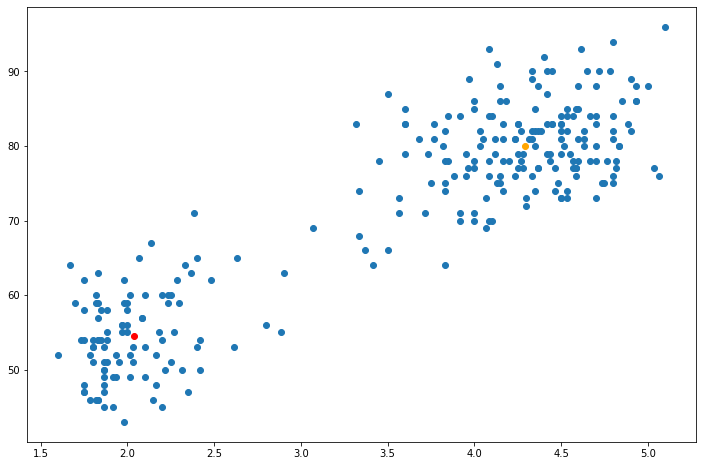

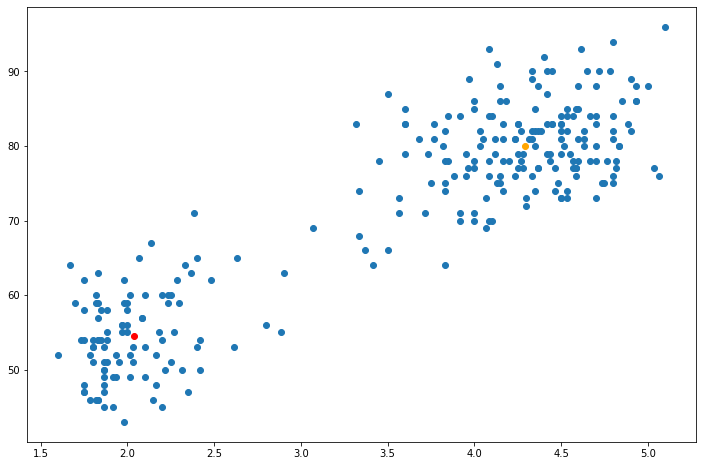

In [7]:

np.random.seed(234)

# Initialization of parameters
#chosen = np.random.choice(len(data), 3, replace=False)
#initial_means = [data[x] for x in chosen]
#initial_covs = [np.cov(data, rowvar=0)] * 3
#initial_weights = [1/3.] * 3

#Two Cluster
initial_means = [np.array([3.467750,70.132353]),np.array([3.5078162,71.6617647])]
initial_covs = [np.array([[1.2975376,13.9110994],[13.911099,183.559040]])]*2
initial_weights = [0.50062804,0.49937196]

#Three Cluster
#initial_means = [np.array([3.4459639,69.8433735]),np.array([3.6217053,72.1578947]),np.array([3.3893617,70.5531915])]
#initial_covs = [np.array([[1.2877935,13.842302],[13.8423020,183.208932]])]*3
#initial_weights = [0.30514706,0.34926471,0.34558824]

# Run EM 
results = EM(X, initial_means, initial_covs, initial_weights)

In [8]:
results['weights']

[0.3558728571174894, 0.6441271428825103]

In [9]:
results['means']

[array([ 2.03638845, 54.47851638]), array([ 4.28966197, 79.96811517])]

In [10]:
results['covs'][0]

array([[ 0.06916767,  0.43516762],
       [ 0.43516762, 33.69728207]])

In [14]:
initial_means = [np.array([3.4459639,69.8433735]),np.array([3.6217053,72.1578947]), np.array([3.3893617,70.5531915])]
initial_means

[array([ 3.4459639, 69.8433735]),
 array([ 3.6217053, 72.1578947]),
 array([ 3.3893617, 70.5531915])]

In [15]:
initial_covs = [np.array([[1.2877935,13.8423020],[13.842302,183.208932]])]*2
initial_covs

[array([[  1.2877935,  13.842302 ],
        [ 13.842302 , 183.208932 ]]),
 array([[  1.2877935,  13.842302 ],
        [ 13.842302 , 183.208932 ]])]

In [16]:
initial_weights = [0.30514706,0.34926471, 0.34558824]
initial_weights

[0.30514706, 0.34926471, 0.34558824]

Iteration : 0 - means:[array([ 3.44630616, 69.85042535]), array([ 3.62064297, 72.13856517]), array([ 3.39011184, 70.56633575])]
Iteration : 1 - means:[array([ 3.43660804, 69.72137797]), array([ 3.63621595, 72.31525135]), array([ 3.38291679, 70.50148676])]
Iteration : 2 - means:[array([ 3.42351954, 69.54024329]), array([ 3.65789994, 72.5610335 ]), array([ 3.37254255, 70.41275219])]
Iteration : 3 - means:[array([ 3.40734429, 69.31384542]), array([ 3.68530248, 72.8707839 ]), array([ 3.35908913, 70.29901903])]
Iteration : 4 - means:[array([ 3.38730876, 69.03567538]), array([ 3.71981131, 73.26035801]), array([ 3.34179192, 70.14953437])]
Iteration : 5 - means:[array([ 3.36210127, 68.69296379]), array([ 3.76375171, 73.75592376]), array([ 3.31936386, 69.94808391])]
Iteration : 6 - means:[array([ 3.32966354, 68.26506744]), array([ 3.82072231, 74.39698842]), array([ 3.28975384, 69.67039693])]
Iteration : 7 - means:[array([ 3.28662509, 67.71834342]), array([ 3.89638639, 75.24372346]), array([ 3.2

/Users/sushanta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration : 23 - means:[array([ 1.9478154 , 53.21655102]), array([ 4.30579334, 80.17218178]), array([ 2.39907662, 59.14632184])]
Iteration : 24 - means:[array([ 1.94614719, 53.21046212]), array([ 4.304963  , 80.16028252]), array([ 2.40142478, 59.16408909])]
Iteration : 25 - means:[array([ 1.94487432, 53.20381639]), array([ 4.30402811, 80.14684739]), array([ 2.39907482, 59.1396903 ])]
Iteration : 26 - means:[array([ 1.94367948, 53.19573237]), array([ 4.3029778 , 80.13179898]), array([ 2.39354288, 59.08431492])]
Iteration : 27 - means:[array([ 1.94236318, 53.18562827]), array([ 4.30180587, 80.11511948]), array([ 2.38570783, 59.0035392 ])]
Iteration : 28 - means:[array([ 1.94078119, 53.17305305]), array([ 4.30051785, 80.09699396]), array([ 2.37620103, 58.90051156])]
Iteration : 29 - means:[array([ 1.93881717, 53.15765512]), array([ 4.29914575, 80.07804786]), array([ 2.36570427, 58.77843473])]
Iteration : 30 - means:[array([ 1.9363825 , 53.13926682]), array([ 4.29775956, 80.05949321]), arr

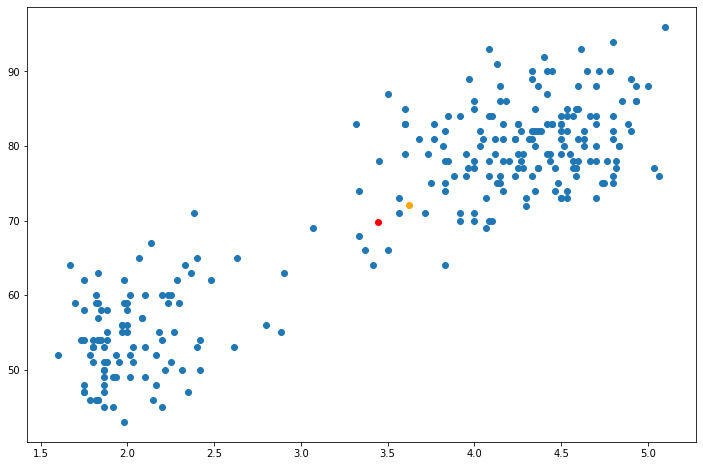

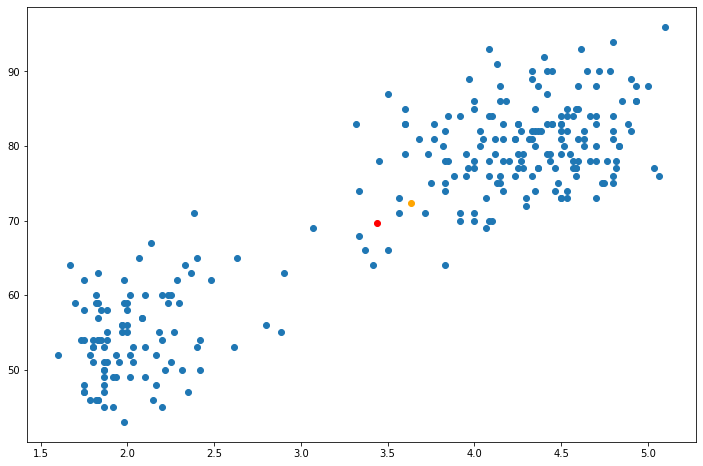

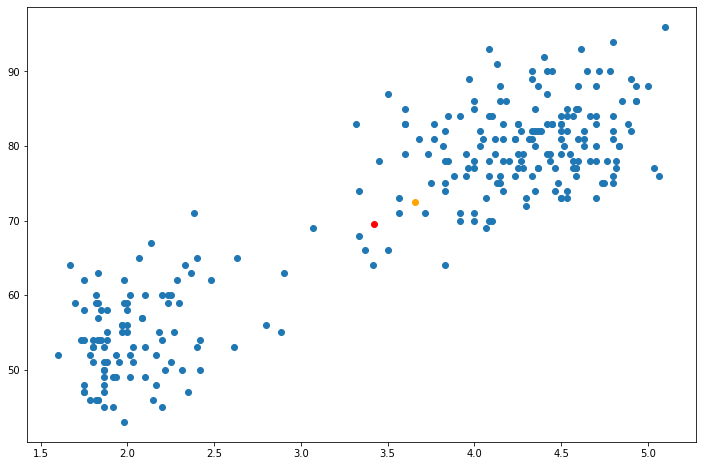

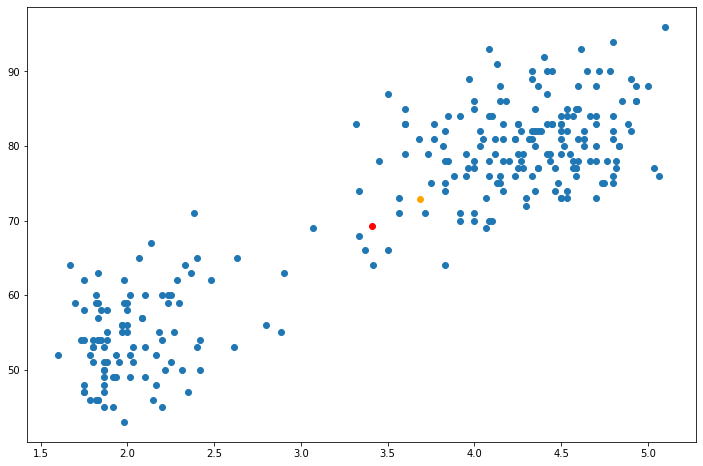

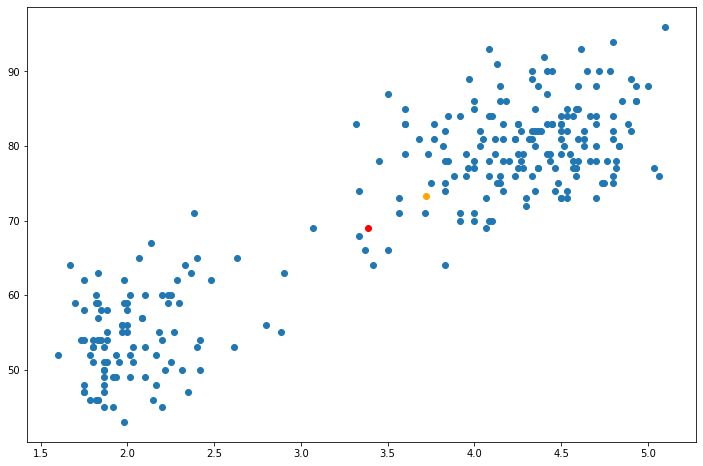

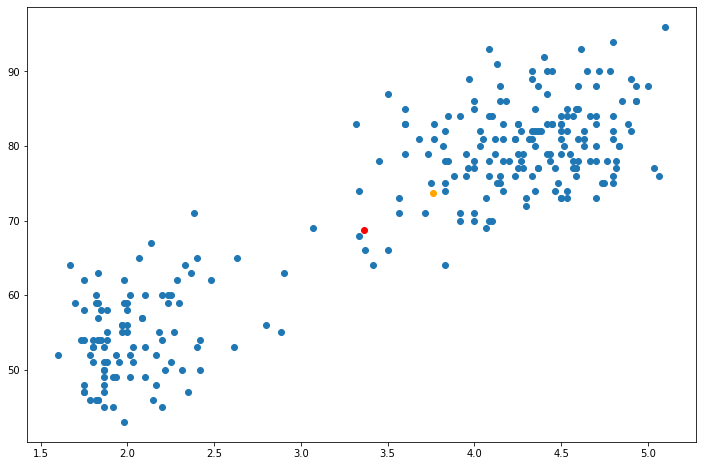

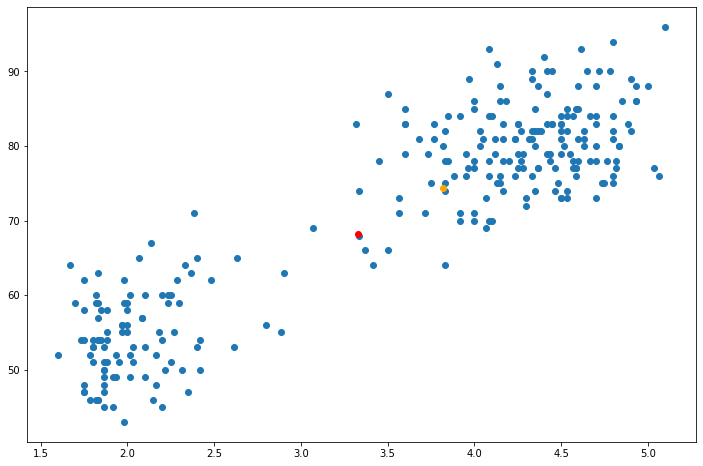

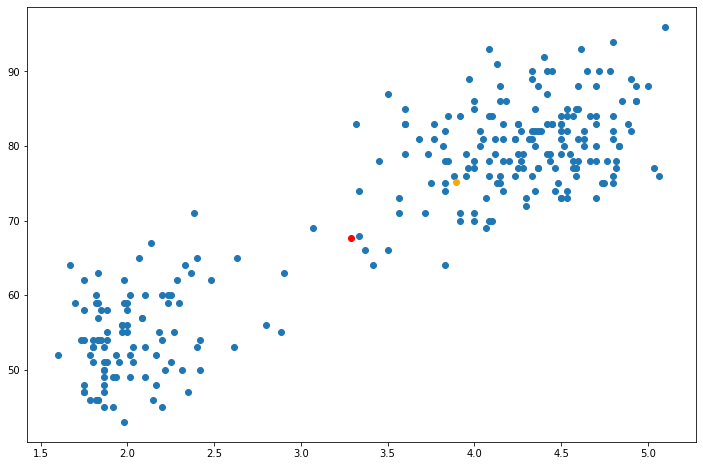

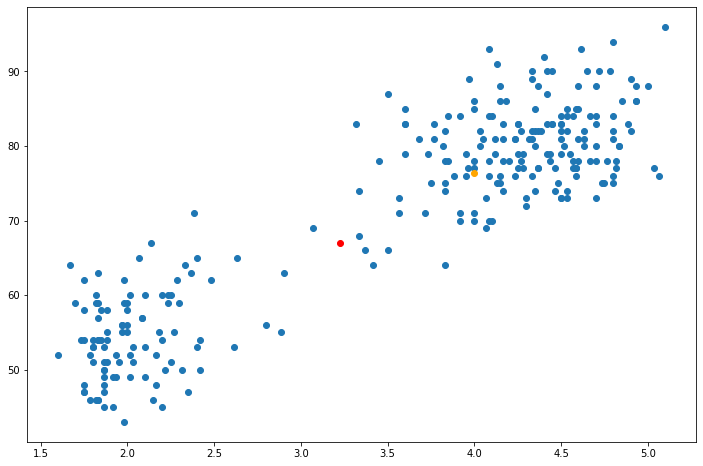

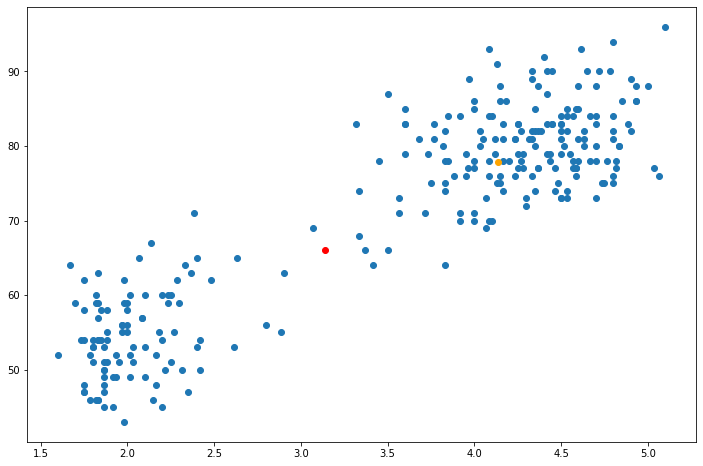

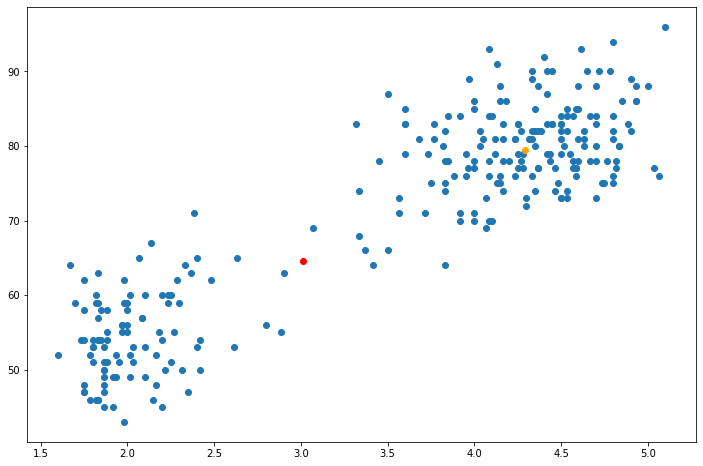

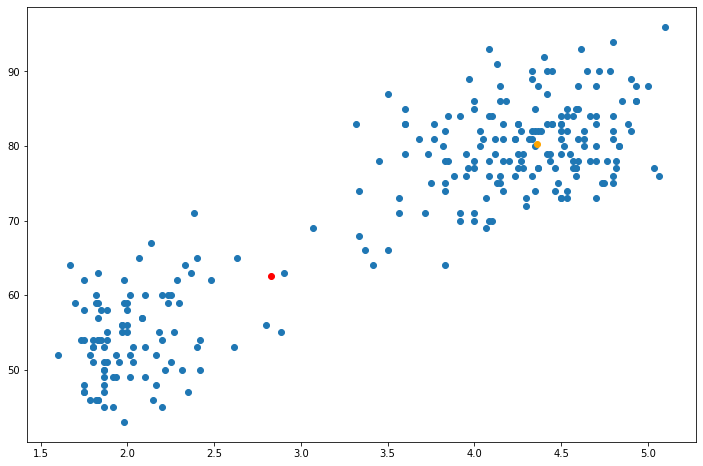

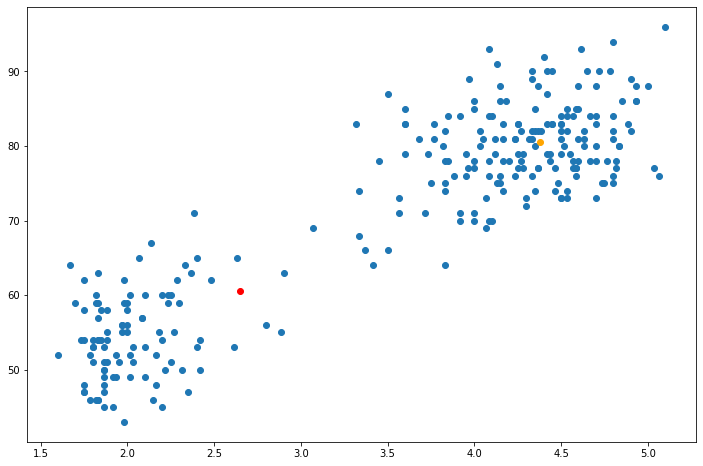

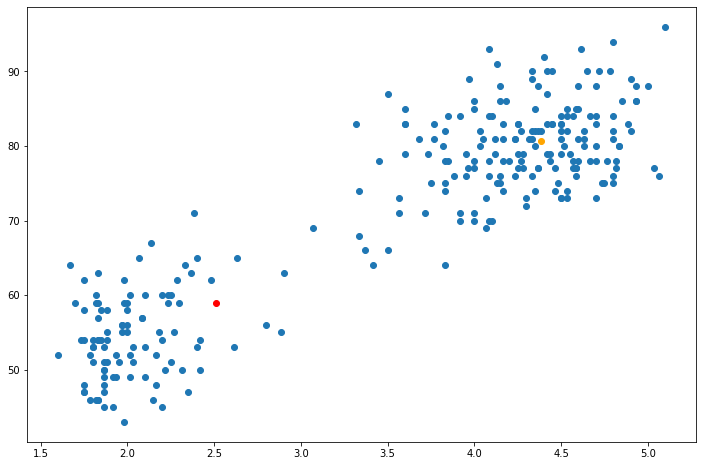

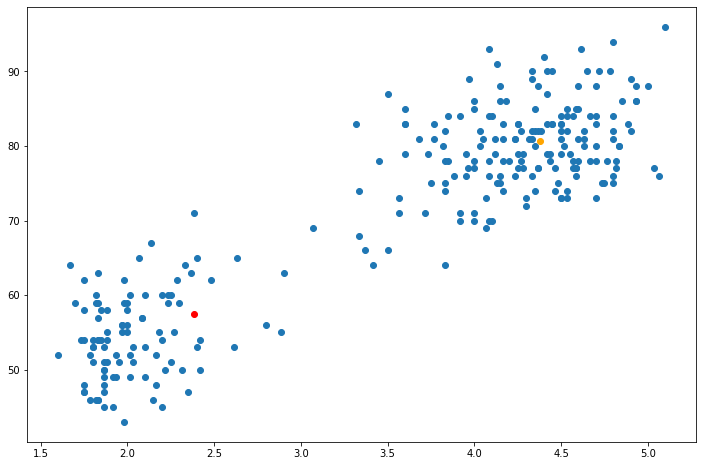

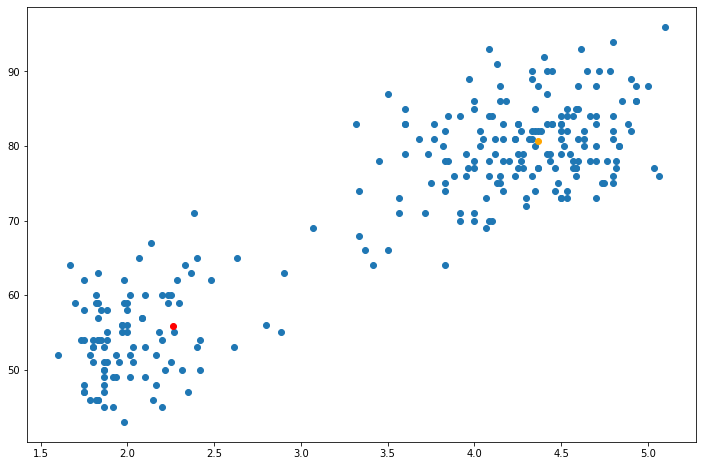

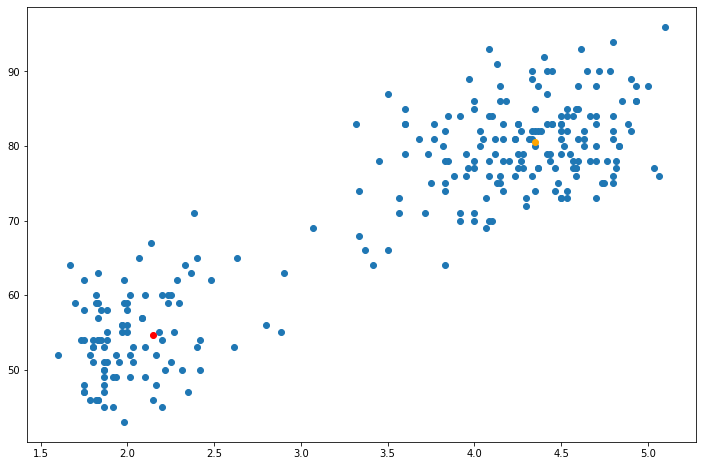

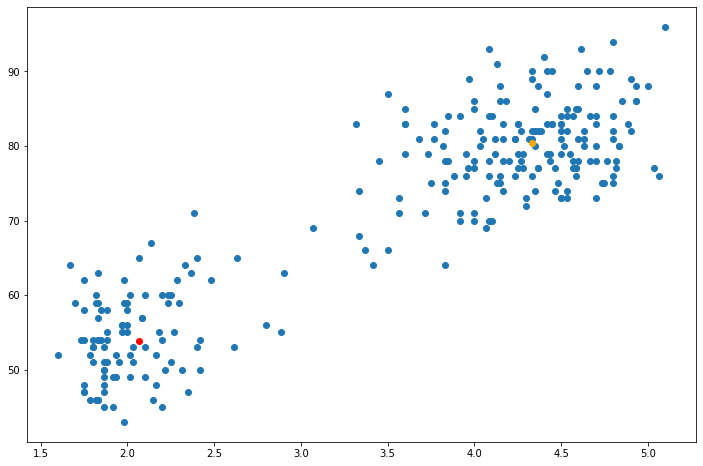

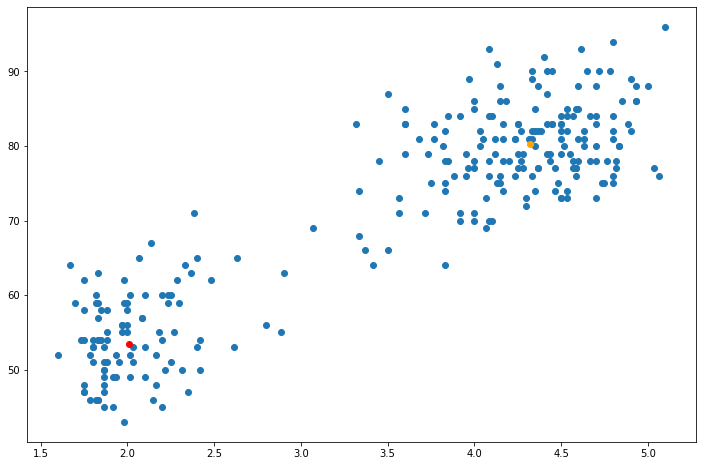

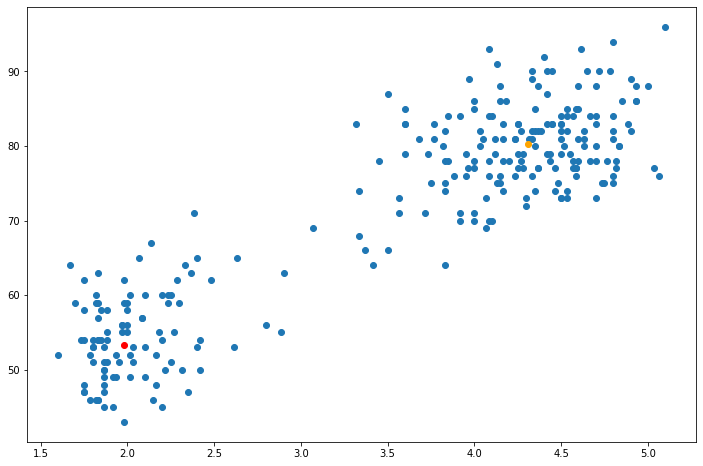

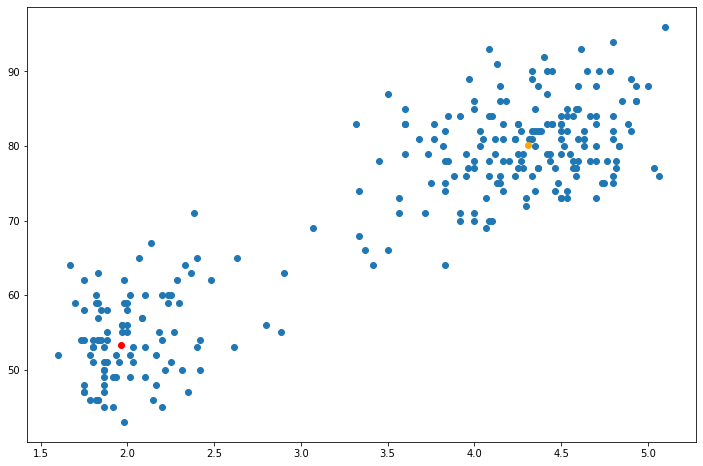

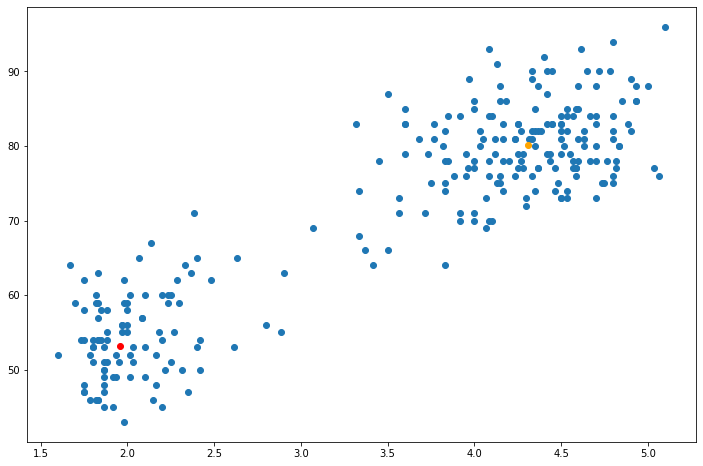

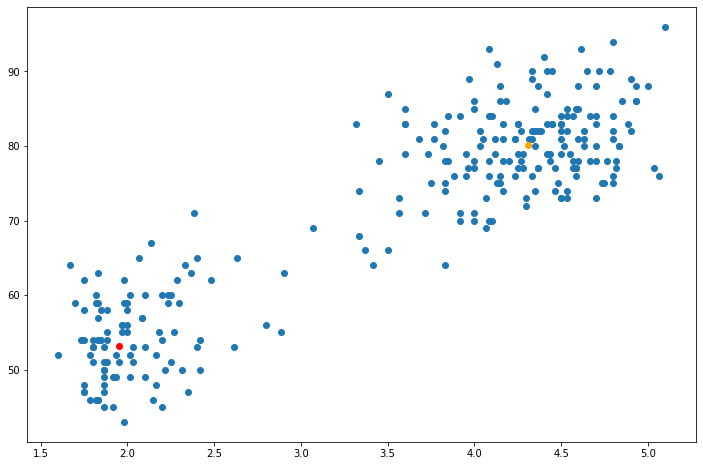

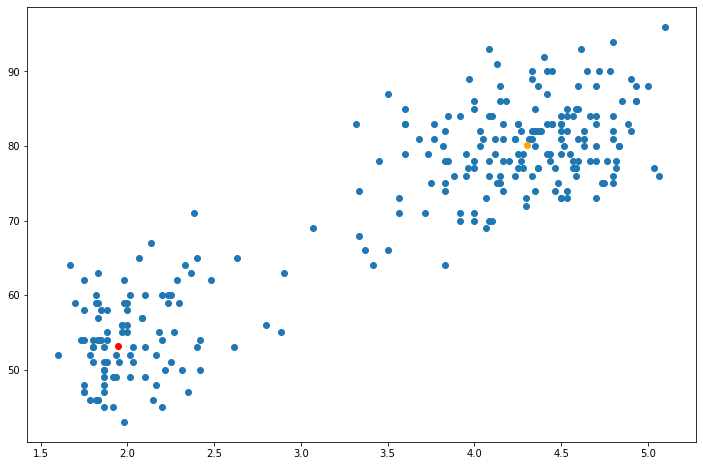

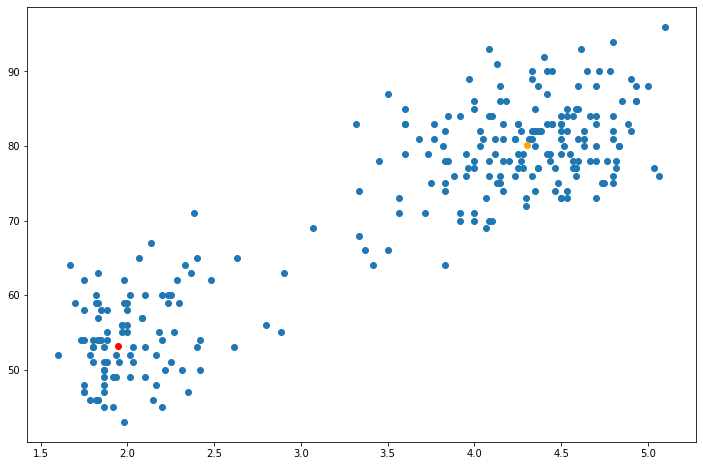

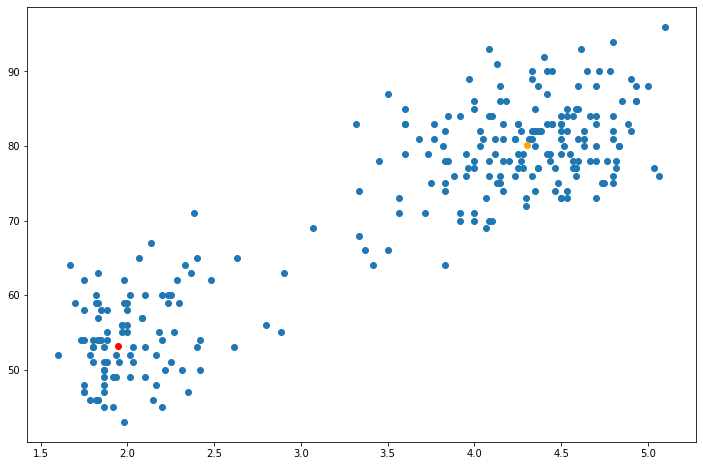

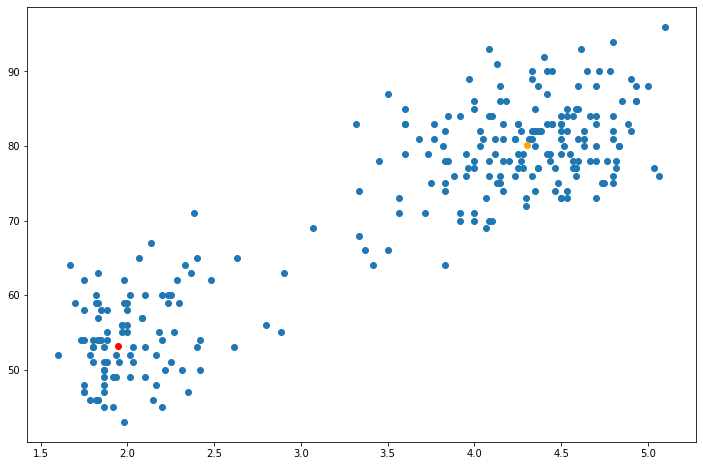

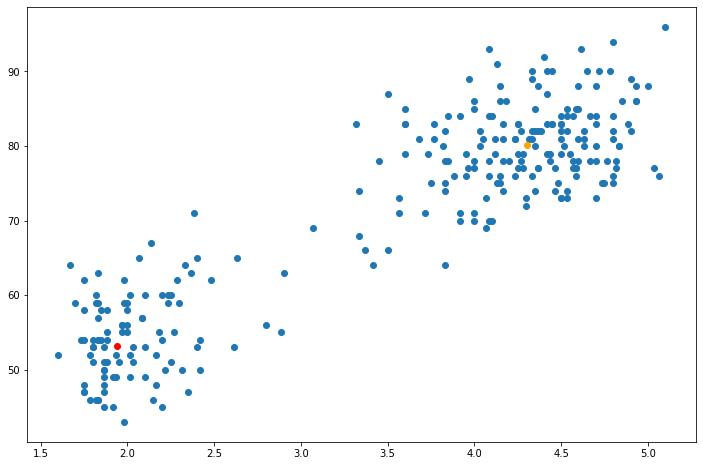

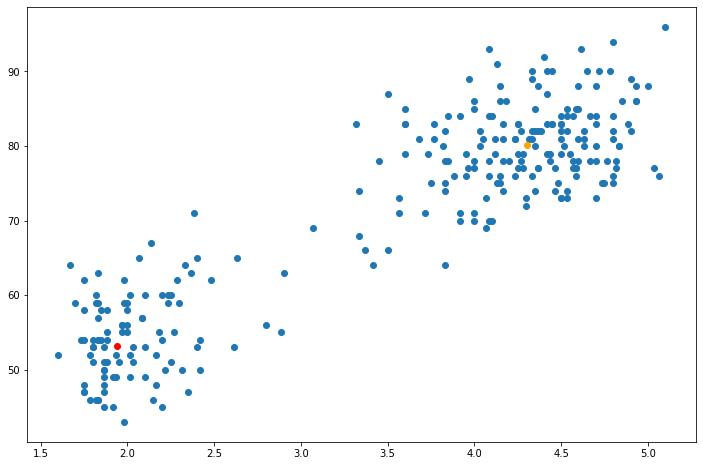

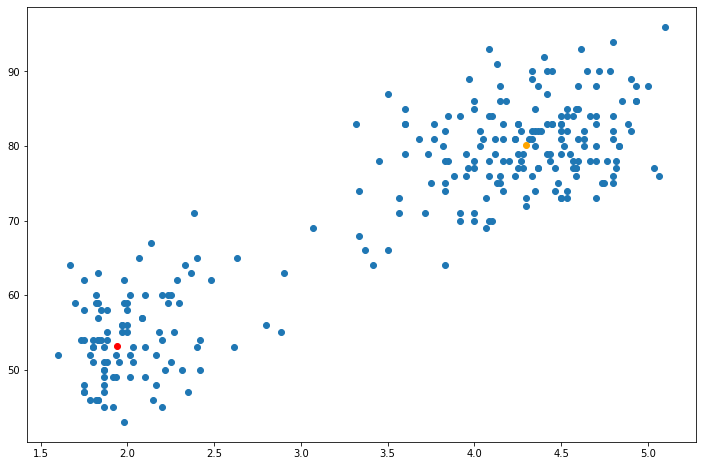

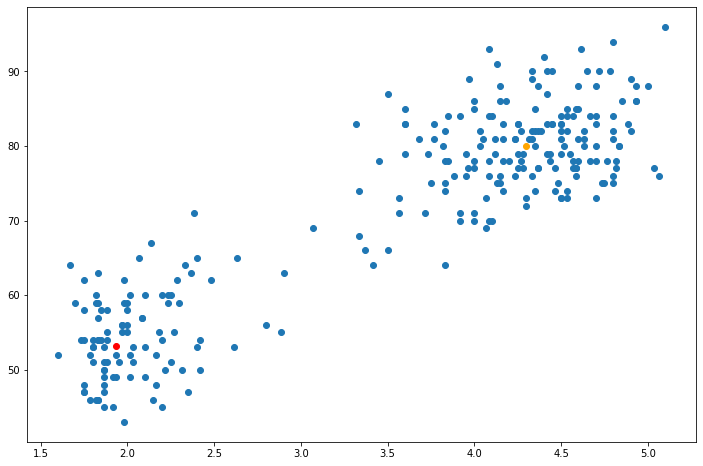

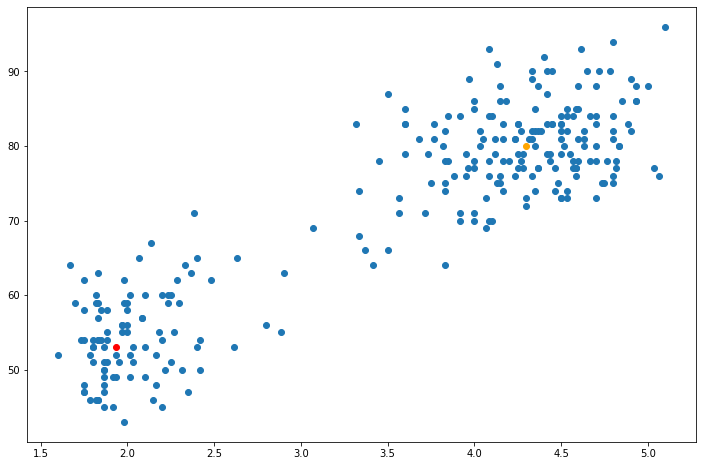

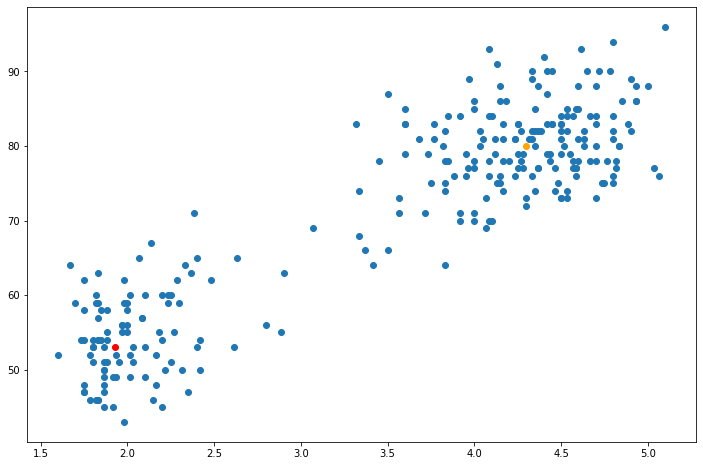

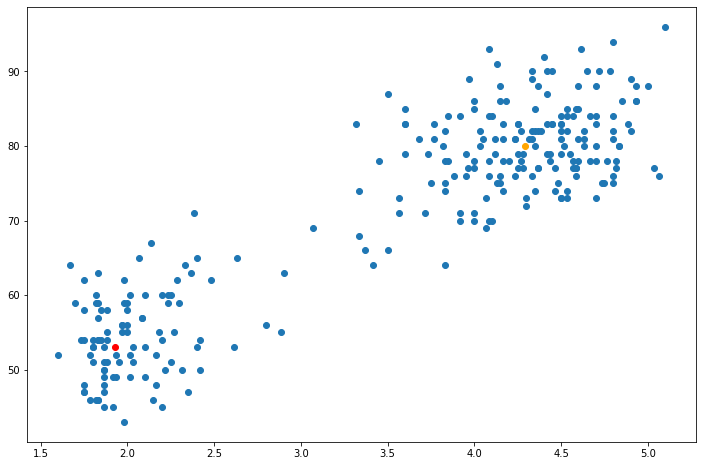

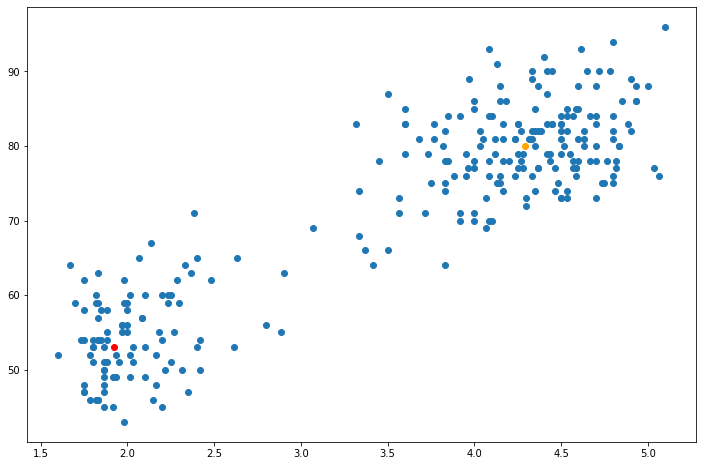

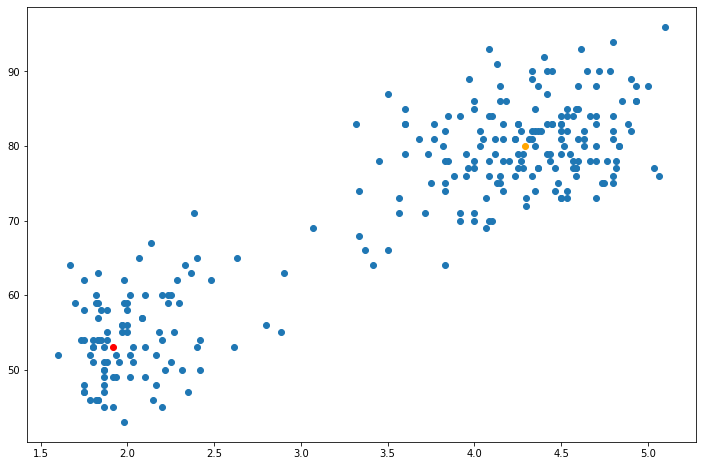

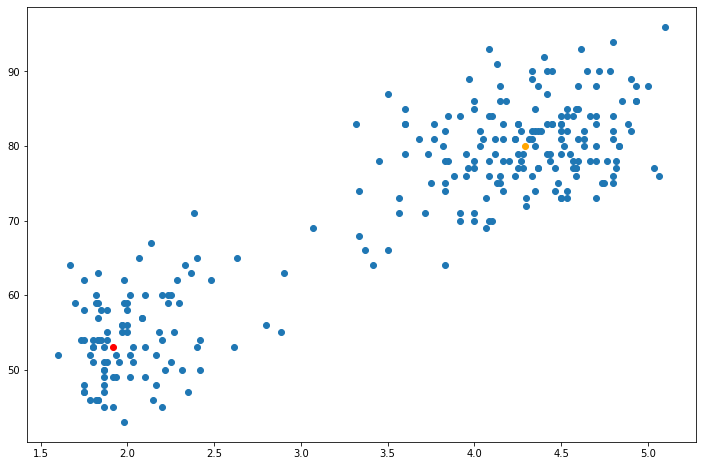

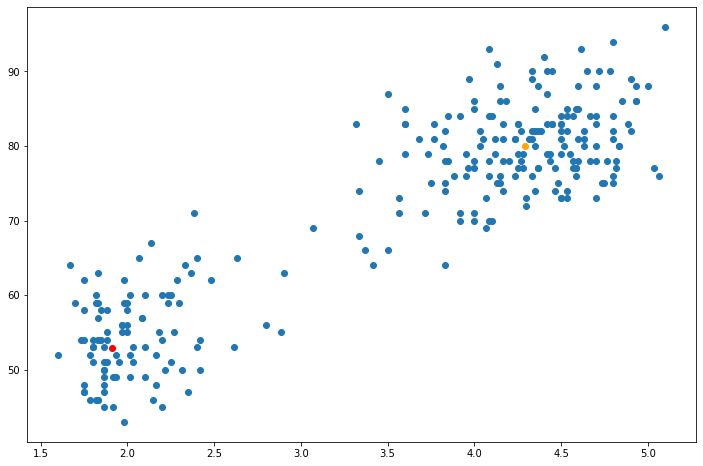

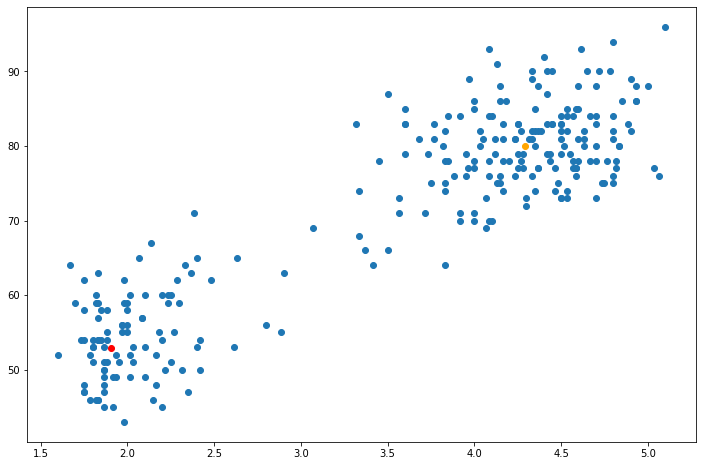

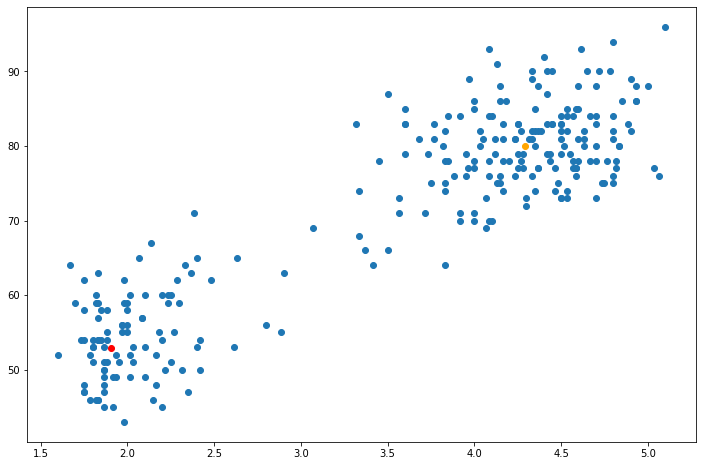

In [18]:

np.random.seed(234)

# Initialization of parameters
#chosen = np.random.choice(len(data), 3, replace=False)
#initial_means = [data[x] for x in chosen]
#initial_covs = [np.cov(data, rowvar=0)] * 3
#initial_weights = [1/3.] * 3

#Two Cluster
#initial_means = [np.array([3.467750,70.132353]),np.array([3.5078162,71.6617647])]
#initial_covs = [np.array([[1.2975376,13.9110994],[13.911099,183.559040]])]*2
#initial_weights = [0.30514706,0.34926471]

#Three Cluster
initial_means = [np.array([3.4459639,69.8433735]),np.array([3.6217053,72.1578947]),np.array([3.3893617,70.5531915])]
initial_covs = [np.array([[1.2877935,13.842302],[13.8423020,183.208932]])]*3
initial_weights = [0.30514706,0.34926471,0.34558824]

# Run EM 
results = EM(X, initial_means, initial_covs, initial_weights)